In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import imutils.paths as path
from tqdm import tqdm
import os
from skimage.io import imread
import cv2
from tqdm import tqdm
import imutils

In [2]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D,BatchNormalization, ZeroPadding2D, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
positifList=os.listdir('brain_tumor_dataset/yes/')
negatifList=os.listdir('brain_tumor_dataset/no/')
nameFile = positifList+negatifList
clsName = os.listdir('brain_tumor_dataset/')

In [4]:
def crop_brain_contour(image, plot=False):
    #convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations = 2)
    
    contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.title('Cropped Image')
        plt.show()
    return new_image

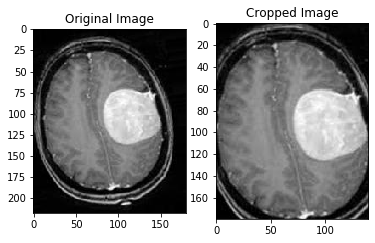

In [5]:
ex_img = cv2.imread('brain_tumor_dataset/yes/aug_Y1_0_1595.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [6]:
def loadCitra (listData, labeling):
    data = []
    label = []
    for i in tqdm (listData):
        if (labeling == 0):
            sample = cv2.imread ('brain_tumor_dataset/yes/'+i)
        elif (labeling == 1):
            sample = cv2.imread ('brain_tumor_dataset/no/'+i)
        sample = crop_brain_contour(sample, plot=False)
        sampleResize = cv2.resize(sample, dsize=(64, 64))
        sampleResize = sampleResize /255. 
        data.append(sampleResize)
        label.append(labeling)
    return (data, label)

mengambil data dari path data untuk yang postif tumor otak yang nama folder dan direktorinya (brain_tumor_dataset/yes/), dan juga mengambil data untuk yang negatif tumor otak dengan nama folder dan direktorinya (brain_tumor_dataset/no/), data yag sudah di masukkan kemudian data akan di hilangkan noise yang tidak perlu dengan fungsi "crop_brain_contour" kemudian data tersebut di rize dan di normalisasi yang data tersebut kemudian di append ke dalam 1 list data

In [7]:
citraPositif, IDpositif=loadCitra(positifList, 0)
citraArrayP = np.array (citraPositif)
print (citraArrayP.shape)
print("panjang IDpositif:" + str(len(IDpositif))+"\n")

citraNegatif, IDnegatif=loadCitra(negatifList, 1)
citraArrayN = np.array (citraNegatif)
print (citraArrayN.shape)
print("panjang IDnegatif: " + str(len(IDnegatif))+"\n")

citra = citraPositif+citraNegatif
ID=IDpositif+IDnegatif
citra = np.array(citra)
IDs=np.array(ID)
print (IDs)
print("Jumlah Citra: " + str(len(citra)))
print("panjang ID: " + str(len(IDs)))

100%|██████████| 1085/1085 [00:03<00:00, 293.72it/s]


(1085, 64, 64, 3)
panjang IDpositif:1085



100%|██████████| 980/980 [00:02<00:00, 346.62it/s]


(980, 64, 64, 3)
panjang IDnegatif: 980

[0 0 0 ... 1 1 1]
Jumlah Citra: 2065
panjang ID: 2065


mengambil data yang di load pada fungsi "loadCitra" dan juga menampilkan ukuran data dan ukuran shape dari data, setelah itu data di tampilan dengan kelasnya pada code dibawah ini dengan menampilkan 5 data pada masing - masing kelas

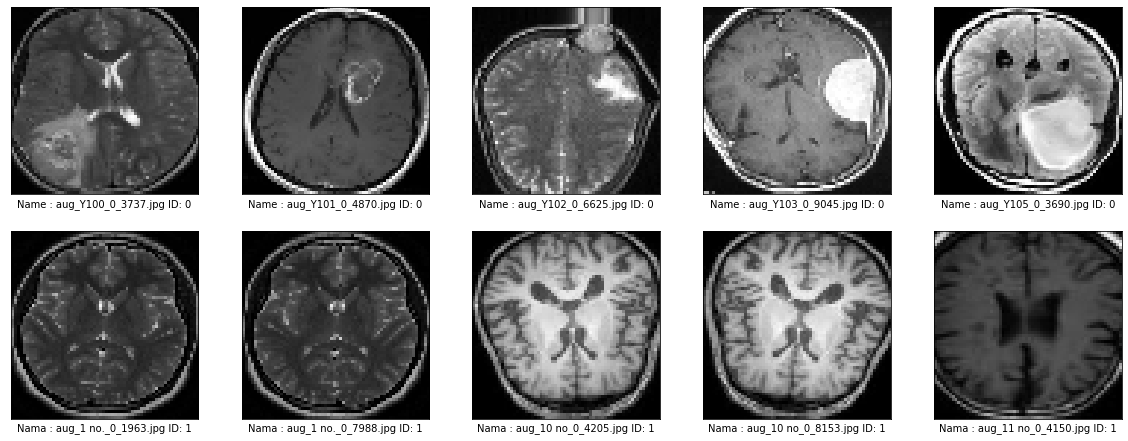

In [8]:
plt.figure(figsize=(20,20))
idx=0;
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    if (i<5):
        plt.imshow(citra[idx], cmap=plt.cm.Greys_r)
        plt.xlabel("Name : {}".format(nameFile[idx])+ " ID: {}".format(IDs[idx]))
        idx+=9
        if i==4:
            idx=len(positifList);
    else:
        plt.imshow(citra[idx], cmap=plt.cm.Greys_r)
        plt.xlabel("Nama : {}".format(nameFile[idx])+ " ID: {}".format(IDs[idx]))
        idx+=6
plt.show()

data yang sudah di load kemudian di tampilkan dengan Id-nya

In [9]:
x_train, x_test, l_train, l_test =  train_test_split(citra, IDs, stratify=IDs, test_size=0.3)
y_train=to_categorical(l_train) 
y_test= to_categorical(l_test)

pada code diatas kemudian berfungsi untuk membagi untuk data menjadi data train dan data test dengan perbadingan 70:30

In [10]:
#Model Preparation
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(64, 64,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        3904      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        20752     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 36)        4

Desain Arsitektur CNN menggunakan aktivasi relu untuk konvolusi dan digabung dengan layer sigmoid sebagai output. Didapatkan nilai keseluruhan paramter CNN memiliki 366,646 parameter dengan mekanisme Dropout.

In [11]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

model dikompile dengan menggunakan binary_crossentropy yang digunakan untuk data dengan klasifikasi biner. Dibantu dengan optimasi adam yang digunakan untuk membantu pemebelajaran mengguanakn binary_crossentropy. untuk membantu diberikan aktifasi output sigmoid

In [12]:
history=model.fit(x_train,
         y_train,
         batch_size=32, #sample_equal
         epochs=150,
         verbose=2, #display model fit
         validation_data=(x_test, y_test))

Epoch 1/150
46/46 - 9s - loss: 0.6955 - acc: 0.5045 - val_loss: 0.6922 - val_acc: 0.5258
Epoch 2/150
46/46 - 9s - loss: 0.6881 - acc: 0.5370 - val_loss: 0.6763 - val_acc: 0.6258
Epoch 3/150
46/46 - 9s - loss: 0.6521 - acc: 0.6367 - val_loss: 0.6385 - val_acc: 0.6500
Epoch 4/150
46/46 - 9s - loss: 0.6186 - acc: 0.6664 - val_loss: 0.5879 - val_acc: 0.7081
Epoch 5/150
46/46 - 9s - loss: 0.5688 - acc: 0.7211 - val_loss: 0.5513 - val_acc: 0.7097
Epoch 6/150
46/46 - 9s - loss: 0.5088 - acc: 0.7592 - val_loss: 0.5168 - val_acc: 0.7710
Epoch 7/150
46/46 - 10s - loss: 0.4574 - acc: 0.7785 - val_loss: 0.4883 - val_acc: 0.7516
Epoch 8/150
46/46 - 9s - loss: 0.4161 - acc: 0.8180 - val_loss: 0.3784 - val_acc: 0.8532
Epoch 9/150
46/46 - 10s - loss: 0.3634 - acc: 0.8318 - val_loss: 0.3485 - val_acc: 0.8500
Epoch 10/150
46/46 - 10s - loss: 0.3091 - acc: 0.8685 - val_loss: 0.3194 - val_acc: 0.8629
Epoch 11/150
46/46 - 10s - loss: 0.2896 - acc: 0.8844 - val_loss: 0.2908 - val_acc: 0.8855
Epoch 12/150
46

In [17]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    

In [18]:
history = model.history.history

history digunakan untuk melihat validasi dari hasil uji arsitektur CNN

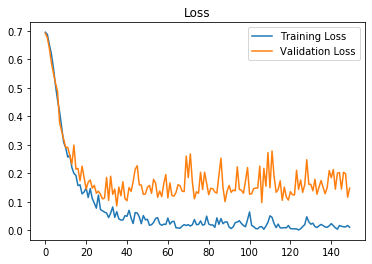

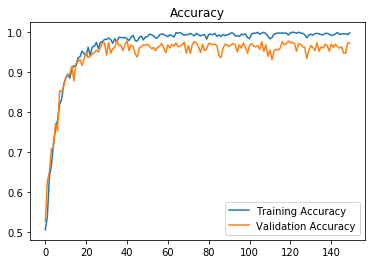

46/46 [==============================] - ETA: 0s - loss: 9.6832e-04 - acc: 1.000 - ETA: 1s - loss: 0.0027 - acc: 1.0000    - ETA: 1s - loss: 0.0033 - acc: 1.000 - ETA: 1s - loss: 0.0030 - acc: 1.000 - ETA: 1s - loss: 0.0024 - acc: 1.000 - ETA: 1s - loss: 0.0020 - acc: 1.000 - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA: 1s - loss: 0.0017 - acc: 1.000 - ETA: 1s - loss: 0.0016 - acc: 1.000 - ETA: 1s - loss: 0.0018 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0015 - acc: 1.000 - ETA: 0s - loss: 0.0014 - acc: 1.000 - ETA: 0s - loss: 0.0014 - acc: 1.000 - ETA: 0s - loss: 0.0013 - acc: 1.000 - ETA: 0s - loss: 0.0013 - acc: 1.000 - ETA: 0s - loss: 0.0013 - acc: 1.000 - ETA: 0s - loss: 0.0012 - acc: 1.000 - ETA: 0s - loss: 0.0012 - acc: 1.000 - ETA: 0s - loss: 0.0012 - acc: 1.000 - ETA: 0s - loss: 0.0012 - acc: 1.000 - ETA: 0s - loss: 0.0012 - acc: 1.000 - 2s 39ms/step - loss: 0.0012 - acc: 1.0000
Trainning accuracy: 1.0
20/20 [====

In [19]:
plot_metrics(history)
test_loss, test_acc = model.evaluate(x_train, y_train)

print('Trainning accuracy:', test_acc)

test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

Hasil training dan evaluasi diatas didapatkan dengan menggunakan epocs 150 mendapatkan data latih sebesar 100% dan akurasi data sebesar 97%.
Dapat disimpulkan dari dua grafik diatas bahwa evaluasi hasil uji dan training mendapatkan hasil yang optimal dan tidak overfitting.

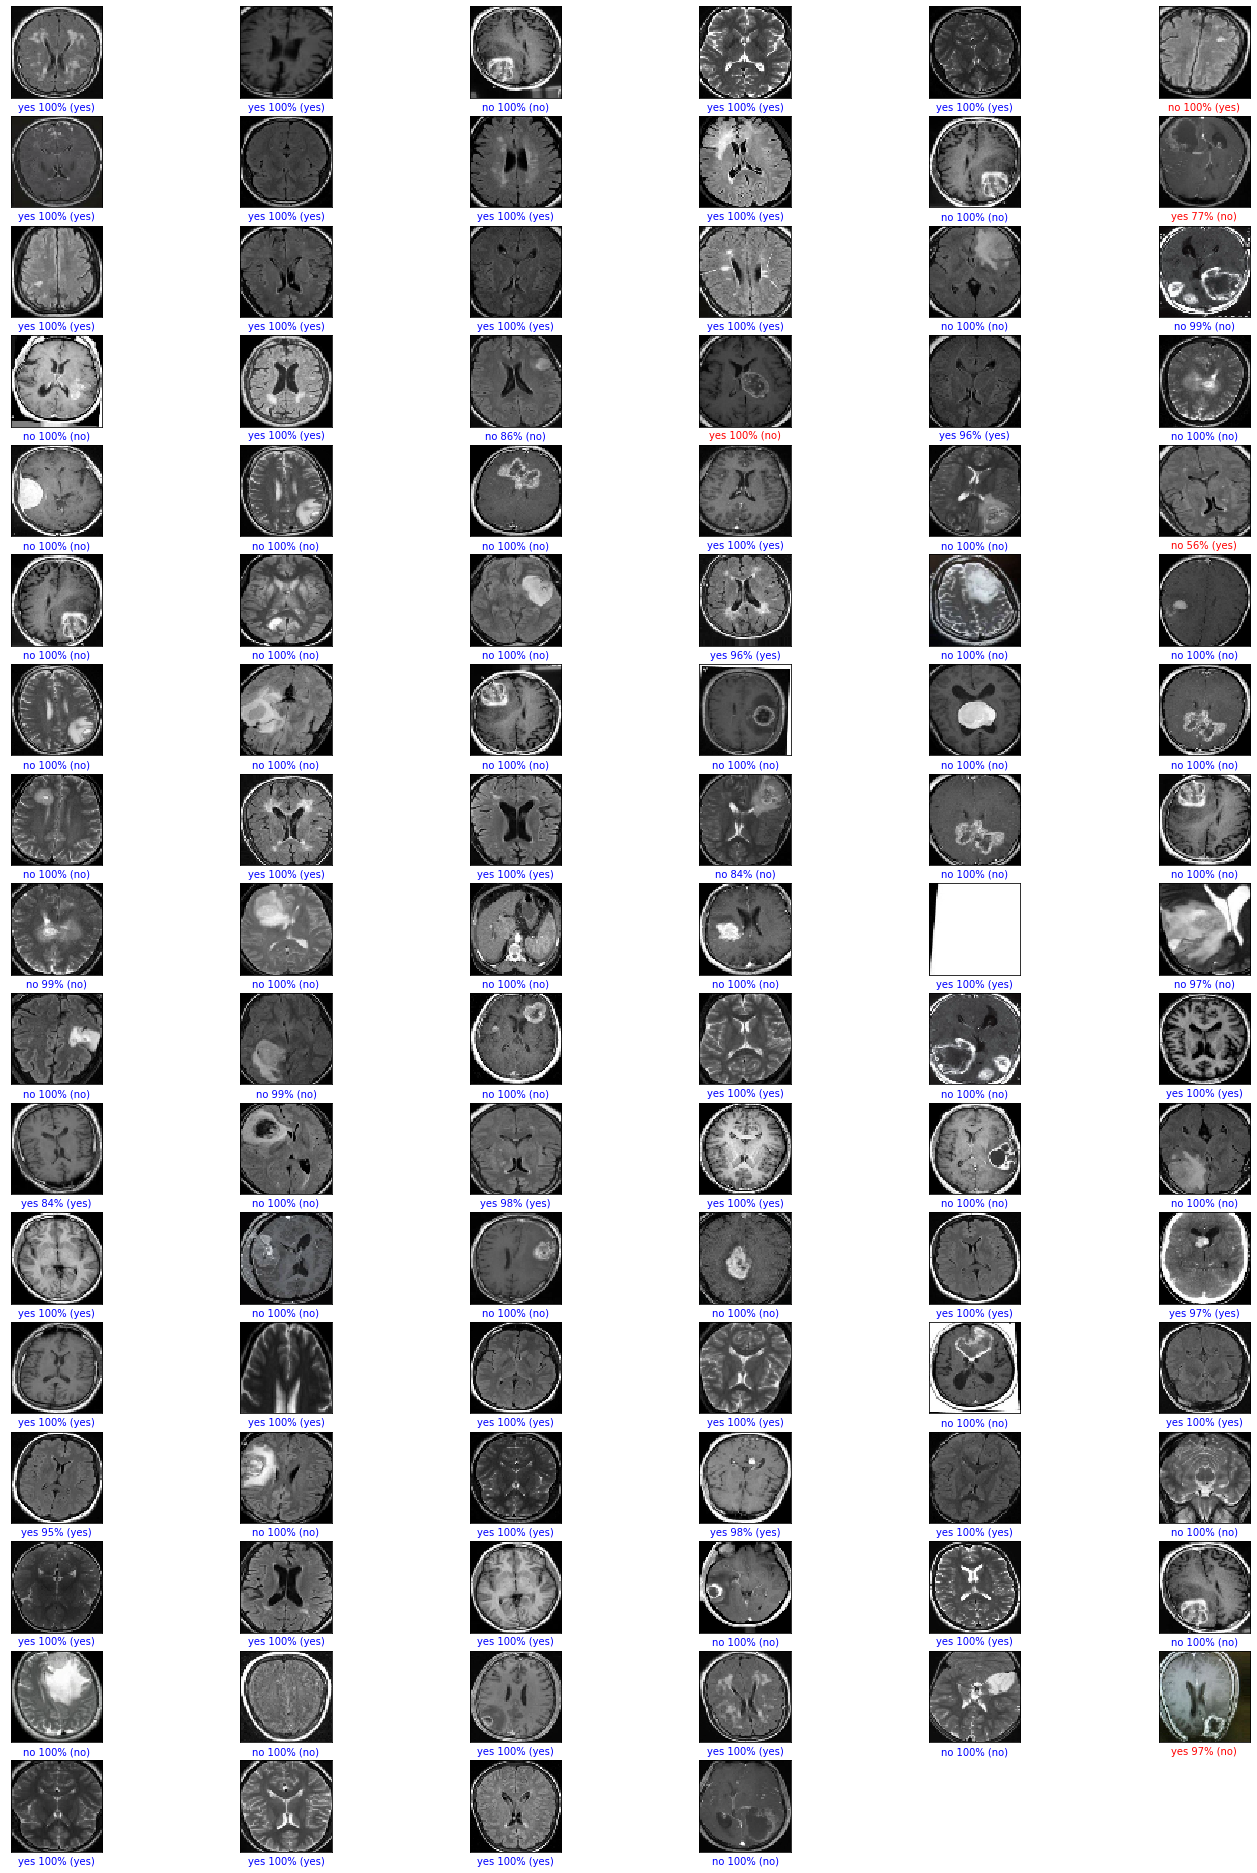

In [22]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img,  cmap=plt.cm.Greys_r)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(clsName[:][predicted_label],
                                100*np.max(predictions_array),
                                clsName[:][true_label]),
                                color=color)



img = np.copy(x_test)
#Vew Results
num_rows = 120/6
num_cols = 6
num_images = len(x_test)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(100):
    plt.subplot(num_rows, num_cols,i+1)
    plot_image(i, predictions, l_test, img)
  #plt.subplot(num_rows, 2*num_cols, 2*i+2)
  #plot_value_array(i, predictions, l_test)
plt.show()

Dari visualisasi data diatas menggunakan implementasi data test, dengan menguji 100 gambar secara acak ada 3-4 citra yang tidak bisa dikenali. selanjutnya untuk melihat hasil CNN yang lebih detail dilakukan pengujian data latih untuk parameter recall, precission, dan f1-score

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def generateClassificationReport(y_test,y_pred):
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))    
    print('accuracy is ',accuracy_score(y_test,y_pred))
    
y_pred=[];
predictions = model.predict(x_test)
for i in range (len(predictions)):
    predicted_label = np.argmax(predictions[i])
    y_pred.append(predicted_label)
generateClassificationReport(l_test,y_pred)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       326
           1       0.97      0.98      0.97       294

    accuracy                           0.97       620
   macro avg       0.97      0.97      0.97       620
weighted avg       0.97      0.97      0.97       620

[[316  10]
 [  7 287]]
accuracy is  0.9725806451612903


Dari hasil confussion matriks untuk hasil true positive didapatkan 316 data terklasifikasi dan untuk true negative didapatkan 287 data terklasifikasi. Akurasi didapatkan sebesar 97% untuk hasil prediksi klasifikasi secara keseluruhan.

hasil precission mendapatkan rasio 0.97 dan 0.98, dan untuk hasil recall mendapatkan rasio 0.97 dan 0.98 dengan hasil total f1-score didapatkan hasil 97%. Dari hasil tersebut disimpulkan hasil klasifikasi menggunakan CNN memiliki akurasi yang baik dengan prediksi akurasi mencapai 97%.